# Proyek Regocnize face
- **Nama:** Novia Ayu Fitriana & Muhammad Akmal

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflow tensorflowjs

In [2]:
# --- Import libraries yang diperlukan ---
import os
import io
import zipfile
import shutil
import unicodedata
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
from google.colab import files

import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Ganti path sesuai lokasi dataset kamu
dataset_path = '/content/drive/MyDrive/dataset-wajah-siswa'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Lihat struktur folder setelah ekstrak
folder_contents = os.listdir(dataset_path)

# Tampilkan isinya
print(folder_contents)

['Novia Ayu Fitriana', 'Siti Mariam', 'Sakti Widi Yulistiani', 'Salsa Nabila', 'Siti Rafika Kyrania', 'Erma Norjanah', 'Riska', 'Muhammad Rizky Aditya', 'Muhammad Ramadhana', 'Arsyad', 'Muhammad Aldo', 'Hikmawan', 'M. Ridho', 'Durrasul', 'Muhammad Anes', 'Muhammad Nurrizky', "Hafizh A'dila", 'Hasbiannur', 'M. Rafli', 'M. Yusuf Pirdaus', 'Muhammad Abdussalam', 'Muhammad Khoirul Anam', 'Nazrie', 'Alvin Husada', 'Muhammad Nabil', 'M. Ridho Ciptana Estu', 'M. Rafiuddin', 'Hamidani', 'Dedy Saputra', 'Ares Fayzaramadhana', 'Ahmad Hairi Aidil', 'Maikel Yonderi U', 'Nur Mila Wati']


In [6]:
# Fungsi normalisasi nama
def normalize_name(name):
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('utf-8')
    name = name.strip().replace(' ', '_').replace("'", "").replace("’", "").lower()
    return name

# Lokasi dataset asal
base_dir = '/content/drive/MyDrive/dataset-wajah-siswa'

# Lokasi baru setelah di-split
output_dir = '/content/dataset-wajah-siswa_split'
os.makedirs(output_dir, exist_ok=True)

# Rasio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Proses setiap class
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Normalisasi nama folder
    norm_name = normalize_name(class_name)

    images = os.listdir(class_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=(1-train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio/(test_ratio+val_ratio)), random_state=42)

    for phase, phase_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        phase_class_dir = os.path.join(output_dir, phase, norm_name)
        os.makedirs(phase_class_dir, exist_ok=True)
        for img in phase_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(phase_class_dir, img))

print("✅ Dataset berhasil di-split ke dalam train/val/test dengan nama yang dinormalisasi!")

✅ Dataset berhasil di-split ke dalam train/val/test dengan nama yang dinormalisasi!


In [7]:
# Cek jumlah class setelah split:
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    '/content/dataset-wajah-siswa_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print("Jumlah class:", train_generator.num_classes)
print("Class index:", train_generator.class_indices)


Found 660 images belonging to 33 classes.
Jumlah class: 33
Class index: {'ahmad_hairi_aidil': 0, 'alvin_husada': 1, 'ares_fayzaramadhana': 2, 'arsyad': 3, 'dedy_saputra': 4, 'durrasul': 5, 'erma_norjanah': 6, 'hafizh_adila': 7, 'hamidani': 8, 'hasbiannur': 9, 'hikmawan': 10, 'm._rafiuddin': 11, 'm._rafli': 12, 'm._ridho': 13, 'm._ridho_ciptana_estu': 14, 'm._yusuf_pirdaus': 15, 'maikel_yonderi_u': 16, 'muhammad_abdussalam': 17, 'muhammad_aldo': 18, 'muhammad_anes': 19, 'muhammad_khoirul_anam': 20, 'muhammad_nabil': 21, 'muhammad_nurrizky': 22, 'muhammad_ramadhana': 23, 'muhammad_rizky_aditya': 24, 'nazrie': 25, 'novia_ayu_fitriana': 26, 'nur_mila_wati': 27, 'riska': 28, 'sakti_widi_yulistiani': 29, 'salsa_nabila': 30, 'siti_mariam': 31, 'siti_rafika_kyrania': 32}


In [8]:
train_dir = 'dataset-wajah-siswa_split/train'
valid_dir = 'dataset-wajah-siswa_split/val'
test_dir = 'dataset-wajah-siswat_split/test'

### Data Preprocessing

#### Split Dataset

In [9]:
# Path utama
base_dir = 'dataset-wajah-siswa_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Fungsi untuk menghitung jumlah gambar per kategori
def count_images(directory):
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            print(f"Kategori '{category}': {num_images} gambar")

# Hitung isi setiap folder
print("Jumlah gambar di TRAIN folder:")
count_images(train_dir)

print("\nJumlah gambar di VAL folder:")
count_images(val_dir)

print("\nJumlah gambar di TEST folder:")
count_images(test_dir)

Jumlah gambar di TRAIN folder:
Kategori 'arsyad': 20 gambar
Kategori 'nur_mila_wati': 20 gambar
Kategori 'hamidani': 20 gambar
Kategori 'muhammad_nurrizky': 20 gambar
Kategori 'muhammad_ramadhana': 20 gambar
Kategori 'muhammad_anes': 20 gambar
Kategori 'sakti_widi_yulistiani': 20 gambar
Kategori 'muhammad_khoirul_anam': 20 gambar
Kategori 'siti_mariam': 20 gambar
Kategori 'alvin_husada': 20 gambar
Kategori 'dedy_saputra': 20 gambar
Kategori 'maikel_yonderi_u': 20 gambar
Kategori 'riska': 20 gambar
Kategori 'm._rafiuddin': 20 gambar
Kategori 'm._ridho': 20 gambar
Kategori 'm._rafli': 20 gambar
Kategori 'ares_fayzaramadhana': 20 gambar
Kategori 'm._ridho_ciptana_estu': 20 gambar
Kategori 'novia_ayu_fitriana': 20 gambar
Kategori 'muhammad_abdussalam': 20 gambar
Kategori 'durrasul': 20 gambar
Kategori 'hafizh_adila': 20 gambar
Kategori 'm._yusuf_pirdaus': 20 gambar
Kategori 'salsa_nabila': 20 gambar
Kategori 'hasbiannur': 20 gambar
Kategori 'muhammad_aldo': 20 gambar
Kategori 'muhammad_riz

In [10]:
train_dir = '/content/dataset-wajah-siswa_split/train'
folders = sorted(os.listdir(train_dir))
print(f"Total folder di train: {len(folders)}")
print("Contoh nama folder:", folders[:10])


Total folder di train: 33
Contoh nama folder: ['ahmad_hairi_aidil', 'alvin_husada', 'ares_fayzaramadhana', 'arsyad', 'dedy_saputra', 'durrasul', 'erma_norjanah', 'hafizh_adila', 'hamidani', 'hasbiannur']


In [11]:
# Path utama
base_dir = 'dataset-wajah-siswa_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Fungsi untuk menghitung total gambar dalam folder
def count_total_images(directory):
    total = 0
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            total += len(os.listdir(category_path))
    return total

# Hitung total
total_train = count_total_images(train_dir)
total_val = count_total_images(val_dir)
total_test = count_total_images(test_dir)

# Cetak hasil
print(f"Total gambar di TRAIN: {total_train}")
print(f"Total gambar di VAL: {total_val}")
print(f"Total gambar di TEST: {total_test}")


Total gambar di TRAIN: 660
Total gambar di VAL: 165
Total gambar di TEST: 165


In [12]:
# Preprocessing dan Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)


In [13]:
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 660 images belonging to 33 classes.
Found 165 images belonging to 33 classes.
Found 165 images belonging to 33 classes.


## Modelling

In [15]:
model = tf.keras.Sequential([
   tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(33, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [18]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [19]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[early_stop, lr_reduce]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.0285 - loss: 3.6459 - val_accuracy: 0.1212 - val_loss: 3.5608 - learning_rate: 1.0000e-04
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.0733 - loss: 3.5656 - val_accuracy: 0.2061 - val_loss: 3.4201 - learning_rate: 1.0000e-04
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.1087 - loss: 3.4557 - val_accuracy: 0.2545 - val_loss: 3.1138 - learning_rate: 1.0000e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.1428 - loss: 3.1763 - val_accuracy: 0.3273 - val_loss: 2.6860 - learning_rate: 1.0000e-04
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.1900 - loss: 2.9338 - val_accuracy: 0.4242 - val_loss: 2.2827 - learning_rate: 1.0000e-04
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.2135 - loss: 2.7410 - val_accuracy: 0.4727 - val_loss: 2.0486 - learning_rate: 1.0000e-04
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.2964 - los

## Evaluasi dan Visualisasi

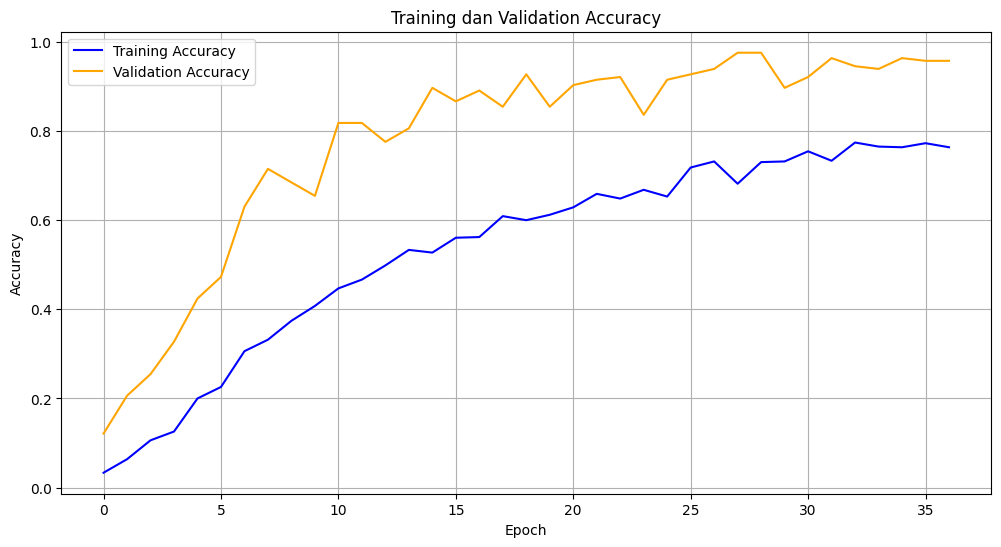

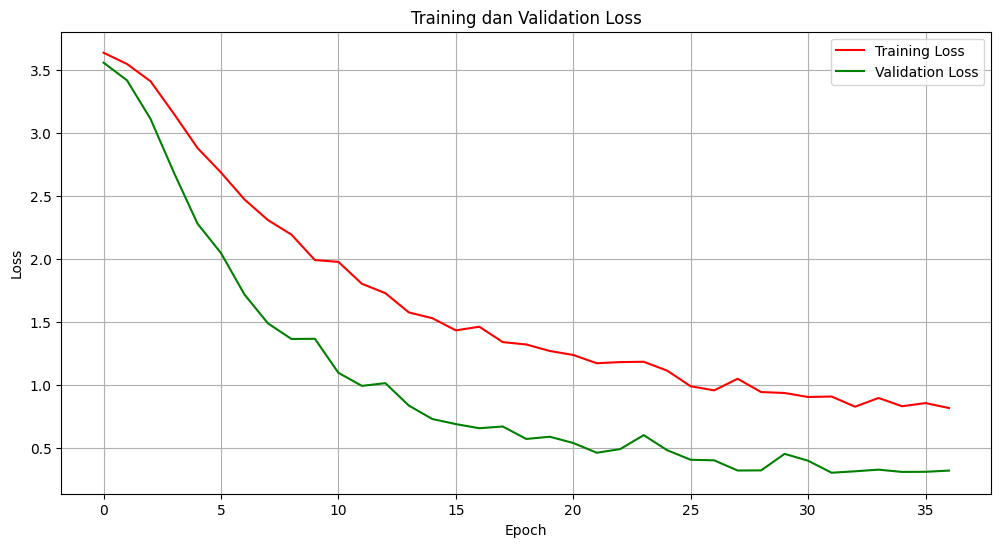

In [20]:
# Plot Akurasi
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training dan Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Training dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Evaluasi model pada data latih
train_loss, train_acc = model.evaluate(train_generator)
print(f"Akurasi Data Latih: {train_acc:.2%}")

# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi Data Uji: {test_acc:.2%}")

# Mengecek apakah akurasi lebih dari 85%
if train_acc >= 0.85 and test_acc >= 0.85:
    print("Akurasi pada training dan testing set sudah memenuhi kriteria 85%!")
else:
    print("Akurasi belum mencapai target 85%.")


21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8698 - loss: 0.6124
Akurasi Data Latih: 86.82%
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9794 - loss: 0.2870
Akurasi Data Uji: 96.97%
Akurasi pada training dan testing set sudah memenuhi kriteria 85%!


## Konversi Model

In [22]:
# Save model in SavedModel format
tf.saved_model.save(model, 'saved_model')

In [23]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Save TFLite model
with open('dataset-wajah-siswa.tflite', 'wb') as f:
    f.write(tflite_model)

In [24]:
os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

In [25]:
label = ['Sakti Widi Yulistiani', 'Salsa Nabila', 'Siti Rafika Kyrania', 'Erma Norjanah', 'Riska', 'Muhammad Rizky Aditya', 'Muhammad Ramadhana', 'Arsyad', 'Muhammad Aldo', 'Hikmawan', 'M. Ridho', 'Durrasul', 'Muhammad Anes', 'Muhammad Nurrizky', "Hafizh A'dila", 'Hasbiannur', 'M. Rafli', 'M. Yusuf Pirdaus', 'Muhammad Abdussalam', 'Muhammad Khoirul Anam', 'Nazrie', 'Alvin Husada', 'Muhammad Nabil', 'M. Ridho Ciptana Estu', 'M. Rafiuddin', 'Hamidani', 'Dedy Saputra', 'Ares Fayzaramadhana', 'Ahmad Hairi Aidil', 'Maikel Yonderi U', 'Nur Mila Wati', 'Nida’an Khafiyya', 'Muhammad Akmal']
with open('label.txt', 'w') as f:
    f.write('\n'.join(label))

In [26]:
pip install tensorflowjs

In [27]:
!tensorflowjs_converter --version

2025-06-12 09:03:53.506026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749719033.533168   22981 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749719033.541164   22981 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!

tensorflowjs 4.22.0

Dependency versions:
  keras 2.18.0
  tensorflow 2.18.0


In [28]:
# Convert to TensorFlow.js format
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='dense_1/Softmax' --saved_model_tags=serve saved_model/drone_bird_model tfjs_model/

2025-06-12 09:04:04.942508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749719044.966245   23037 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749719044.973207   23037 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
             ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib

In [29]:
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-06-12 09:04:12.033620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749719052.057413   23073 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749719052.064437   23073 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-12 09:04:18.134759: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1749719058.825245   23073 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)

In [37]:
img_path = test_dir + '/arsyad/arsyad13.jpg'

# Periksa apakah file ada
if os.path.exists(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Map label
    class_indices = train_generator.class_indices
    labels = dict((v, k) for k, v in class_indices.items())

    print(f'Gambar ini diprediksi sebagai: {labels[predicted_class]}')
else:
    print(f"File gambar tidak ditemukan di path: {img_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Gambar ini diprediksi sebagai: arsyad


Saving hamidani24.jpg to hamidani24.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


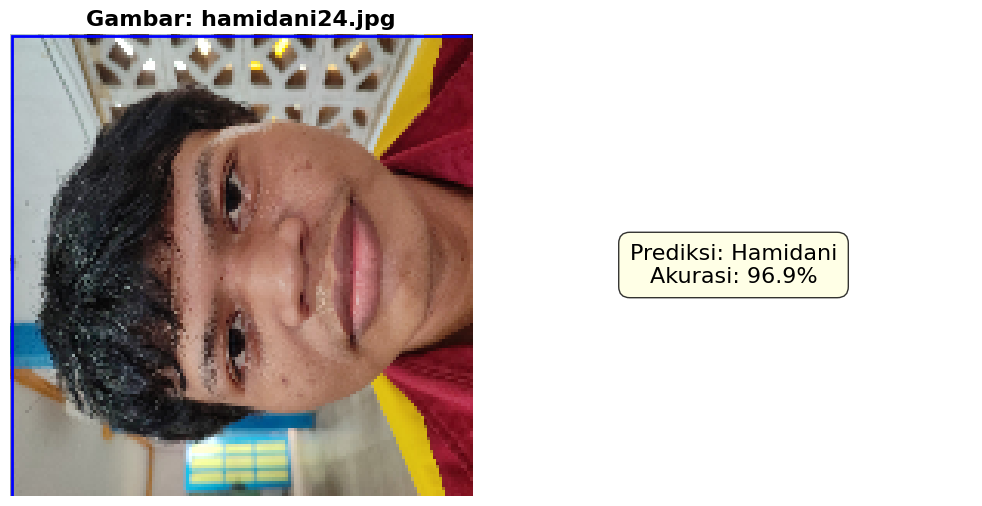


Hasil: Hamidani (96.9% akurat)


In [48]:
# Unggah gambar yang ingin diprediksi
uploaded = files.upload()

for filename in uploaded.keys():
    # Membaca gambar yang di-upload
    img_bytes = uploaded[filename]
    img = image.load_img(io.BytesIO(img_bytes), target_size=(150, 150))

    # Mengubah gambar menjadi array dan melakukan normalisasi
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class_idx = np.argmax(prediction)  # Index kelas dengan prediksi tertinggi
    confidence_pct = np.max(prediction) * 100  # Akurasi prediksi dalam persen

    # Mapping dari index ke nama kelas
    class_indices = {'Ahmad Hairi Aidil': 0, 'Alvin Husada': 1, 'Ares Fayzaramadhana': 2, 'Arsyad': 3, 'Dedy Saputra': 4, 'Durrasul': 5, 'Erma Norjanah': 6, "Hafizh A'dila": 7, 'Hamidani': 8, 'Hasbiannur': 9, 'Hikmawan': 10, 'M. Rafiuddin': 11, 'M. Rafli': 12, 'M. Ridho': 13, 'M. Ridho Ciptana Estu': 14, 'M. Yusuf Pirdaus': 15, 'Maikel Yonderi U': 16, 'Muhammad Abdussalam': 17, 'Muhammad Akmal': 18, 'Muhammad Aldo': 19, 'Muhammad Anes': 20, 'Muhammad Khoirul Anam': 21, 'Muhammad Nabil': 22, 'Muhammad Nurrizky': 23, 'Muhammad Ramadhana': 24, 'Muhammad Rizky Aditya': 25, 'Nazrie': 26, 'Nida’an Khafiyya': 27, 'Nur Mila Wati': 28, 'Riska': 29, 'Sakti Widi Yulistiani': 30, 'Salsa Nabila': 31, 'Siti Rafika Kyrania': 32}  # Sesuaikan dengan class index modelmu
    predicted_class = list(class_indices.keys())[predicted_class_idx]

    # Menampilkan gambar dan hasil prediksi
    plt.figure(figsize=(10, 5))

    # Gambar asli
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Gambar: {filename}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((0, 0), 150, 150, linewidth=2, edgecolor='blue', facecolor='none'))

    # Hasil prediksi
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5,
             f"Prediksi: {predicted_class}\nAkurasi: {confidence_pct:.1f}%",
             fontsize=16,
             ha='center', va='center',
             bbox=dict(facecolor='lightyellow', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Cetak hasil di konsol
    print(f"\nHasil: {predicted_class} ({confidence_pct:.1f}% akurat)")

In [32]:
# !pip freeze > requirements.txt

In [33]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
!zip -r saved_model.zip saved_model
!zip -r tfjs_model.zip tfjs_model
!zip -r tflite.zip tflite
files.download('label.txt')

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 62%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: saved_model/saved_model.pb (deflated 87%)
  adding: saved_model/assets/ (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 88%)
  adding: tfjs_model/group1-shard13of19.bin (deflated 8%)
  adding: tfjs_model/group1-shard4of19.bin (deflated 8%)
  adding: tfjs_model/group1-shard7of19.bin (deflated 8%)
  adding: tfjs_model/group1-shard15of19.bin (deflated 8%)
  adding: tfjs_model/group1-shard6of19.bin (deflated 8%)
  adding: tfjs_model/group1-shard12of19.bin (deflated 8%)
  adding: tfjs_model/group1-shard1of19.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of19.bin (deflated 8%)
  adding: tfjs_model/group1-shard9of19.bin (deflated 8%)
  adding: tfjs_model/group1-shard17of19.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
from google.colab import files
files.download("saved_model.zip")
files.download("tfjs_model.zip")
files.download("tflite.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>